## Diffusion Model for Image Generation

This is an ongoing project to implement a diffusion model to generate fluoroscopy images. Starter code was taken from: https://medium.com/mlearning-ai/enerating-images-with-ddpms-a-pytorch-implementation-cef5a2ba8cb1. Training images are omitted as the dataset is not public.

Changes made include:
1) Modifications to work with custom femur dataset <br>
2) UNet was made bigger: more channels, deeper network, bigger images <br>
3) Train loss plot was added and logged to Weights&Biases <br>
4) Initial investigation into FID metrics <br>

Future goals:
1) Complete implementation of FID for evaluation <br>
2) Add a text encoder

In [ ]:
# Import of libraries
import random
import imageio
import numpy as np
from argparse import ArgumentParser

from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import einops
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models

from torchvision.transforms import Compose, ToTensor, Lambda
from torchvision.datasets.mnist import MNIST, FashionMNIST

import glob
import cv2

import wandb

# Setting reproducibility
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Definitions
STORE_PATH_MNIST = f"ddpm_model_mnist.pt"
STORE_PATH_FASHION = f"ddpm_model_fashion.pt"

In [2]:
no_train = False
fashion = False
batch_size = 128
n_epochs = 20
lr = 0.01
store_path = "ddpm_fashion.pt" if fashion else "ddpm_mnist.pt"

In [3]:
def show_images(images, title=""):
    """Shows the provided images as sub-pictures in a square"""

    # Converting images to CPU numpy arrays
    if type(images) is torch.Tensor:
        images = images.detach().cpu().numpy()

    # Defining number of rows and columns
    fig = plt.figure(figsize=(8, 8))
    rows = int(len(images) ** (1 / 2))
    cols = round(len(images) / rows)

    # Populating figure with sub-plots
    idx = 0
    for r in range(rows):
        for c in range(cols):
            fig.add_subplot(rows, cols, idx + 1)

            if idx < len(images):
                plt.imshow(images[idx][0], cmap="gray")
                idx += 1
    fig.suptitle(title, fontsize=30)

    # Showing the figure
    plt.show()

In [4]:
# Shows the first batch of images
def show_first_batch(loader):
    for batch in loader:
        show_images(batch[0], "Images in the first batch")
        break

In [5]:
def square_crop_fluoro(img):
    # crops an image to have its height match its width.
    # crop is done only on the larger dim.

    h = None
    w = None
    
    if len(img.shape) == 3:
        h, w, _ = img.shape
    else:
        h, w = img.shape
    
    if h > w:
        diff = int(h - w) // 2
        img = img[diff:h-diff:, :]
    else:
        diff = int(w - h) // 2
        img = img[:, diff:w-diff]

    return img

def load_image(image_path, mode, image_size, threshold=False):
    # thresholding fixes JPG artifacts
    img = cv2.imread(image_path, mode)
    img = square_crop_fluoro(img)
    if threshold:
        _, img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
    if image_size != -1:
        img = cv2.resize(img, (image_size, image_size))
    return img

In [6]:
class FemurDataset(Dataset):

    def __init__(self, image_size=-1, preload=False):
        super().__init__()

        self.img_size  = image_size
        self.preload   = preload
        self.transform = transforms.RandomInvert(p=0.05)
        #create a list here
        self.image_list = []

        # load paths from pickle files
        image_paths = []
        image_paths2 = []

        image_paths = glob.glob(r'D:\**\images\*.png', recursive=True)
        image_paths2 = glob.glob(r'D:\images\*.jpg', recursive=True)

        image_paths = image_paths + image_paths2

        self.image_paths = image_paths
        
        for i, image in enumerate(image_paths):
            this = load_image(self.image_paths[i], cv2.IMREAD_GRAYSCALE,     self.img_size, False)
            self.image_list.append(this)
        

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
 
        # image     = load_image(self.image_paths[idx], cv2.IMREAD_GRAYSCALE,     self.img_size, False)
        image = self.image_list[idx]
 
        image_t   = torch.Tensor(image/(255.0)).unsqueeze(0)


 
        return [image_t]

In [7]:
ds = FemurDataset(
    image_size=64,
    preload=False
)

In [8]:
len(ds)

48401

In [9]:
image = ds[0][0]
print(image.shape)

torch.Size([1, 64, 64])


In [10]:
# Loading the data (converting each image into a tensor and normalizing between [-1, 1])
transform = Compose([
    ToTensor(),
    Lambda(lambda x: (x - 0.5) * 2)]
)
ds_fn = FashionMNIST if fashion else MNIST
# dataset = ds_fn("./datasets", download=True, train=True, transform=transform)
loader = DataLoader(ds, batch_size, shuffle=True)

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [12]:
# DDPM class
# Steps for diffusion
# The model is the UNet
class MyDDPM(nn.Module):
    def __init__(self, network, n_steps=200, min_beta=10 ** -4, max_beta=0.02, device=None, image_chw=(1, 64, 64)):
        super(MyDDPM, self).__init__()
        self.n_steps = n_steps
        self.device = device
        self.image_chw = image_chw
        self.network = network.to(device)
        self.betas = torch.linspace(min_beta, max_beta, n_steps).to(
            device)  # Number of steps is typically in the order of thousands
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.tensor([torch.prod(self.alphas[:i + 1]) for i in range(len(self.alphas))]).to(device)

    def forward(self, x0, t, eta=None):
        # Make input image more noisy (we can directly skip to the desired step)
        n, c, h, w = x0.shape
        a_bar = self.alpha_bars[t]

        if eta is None:
            eta = torch.randn(n, c, h, w).to(self.device)

        noisy = a_bar.sqrt().reshape(n, 1, 1, 1) * x0 + (1 - a_bar).sqrt().reshape(n, 1, 1, 1) * eta
        return noisy

    def backward(self, x, t):
        # Run each image through the network for each timestep t in the vector t.
        # The network returns its estimation of the noise that was added.
        return self.network(x, t)

In [13]:
def show_forward(ddpm, loader, device):
    # Showing the forward process
    for batch in loader:
        imgs = batch[0]

        show_images(imgs, "Original images")

        for percent in [0.25, 0.5, 0.75, 1]:
            show_images(
                ddpm(imgs.to(device),
                     [int(percent * ddpm.n_steps) - 1 for _ in range(len(imgs))]),
                f"DDPM Noisy images {int(percent * 100)}%"
            )
        break

In [14]:
def generate_new_images(ddpm, n_samples=16, device=None, frames_per_gif=100, gif_name="sampling.gif", c=1, h=64, w=64):
    """Given a DDPM model, a number of samples to be generated and a device, returns some newly generated samples"""
    frame_idxs = np.linspace(0, ddpm.n_steps, frames_per_gif).astype(np.uint)
    frames = []

    with torch.no_grad():
        if device is None:
            device = ddpm.device

        # Starting from random noise
        x = torch.randn(n_samples, c, h, w).to(device)

        for idx, t in enumerate(list(range(ddpm.n_steps))[::-1]):
            # Estimating noise to be removed
            time_tensor = (torch.ones(n_samples, 1) * t).to(device).long()
            eta_theta = ddpm.backward(x, time_tensor)

            alpha_t = ddpm.alphas[t]
            alpha_t_bar = ddpm.alpha_bars[t]

            # Partially denoising the image
            x = (1 / alpha_t.sqrt()) * (x - (1 - alpha_t) / (1 - alpha_t_bar).sqrt() * eta_theta)

            if t > 0:
                z = torch.randn(n_samples, c, h, w).to(device)

                # sigma_t squared = beta_t
                beta_t = ddpm.betas[t]
                sigma_t = beta_t.sqrt()

                # Adding some more noise like in Langevin Dynamics fashion
                x = x + sigma_t * z

            # Adding frames to the GIF
            if idx in frame_idxs or t == 0:
                # Putting digits in range [0, 255]
                normalized = x.clone()
                for i in range(len(normalized)):
                    normalized[i] -= torch.min(normalized[i])
                    normalized[i] *= 255 / torch.max(normalized[i])

                # Reshaping batch (n, c, h, w) to be a (as much as it gets) square frame
                frame = einops.rearrange(normalized, "(b1 b2) c h w -> (b1 h) (b2 w) c", b1=int(n_samples ** 0.5))
                frame = frame.cpu().numpy().astype(np.uint8)

                # Rendering frame
                frames.append(frame)


    with imageio.get_writer(gif_name, mode="I") as writer:
        for idx, frame in enumerate(frames):
            rgb_frame = np.repeat(frame, 3, axis=2)
            writer.append_data(rgb_frame)
    
            # Showing the last frame for a longer time
            if idx == len(frames) - 1:
                last_rgb_frame = np.repeat(frames[-1], 3, axis=2)
                for _ in range(frames_per_gif // 3):
                    writer.append_data(last_rgb_frame)
    return x

In [15]:
def sinusoidal_embedding(n, d):
    # Returns the standard positional embedding
    embedding = torch.zeros(n, d)
    wk = torch.tensor([1 / 10_000 ** (2 * j / d) for j in range(d)])
    wk = wk.reshape((1, d))
    t = torch.arange(n).reshape((n, 1))
    embedding[:,::2] = torch.sin(t * wk[:,::2])
    embedding[:,1::2] = torch.cos(t * wk[:,::2])

    return embedding

In [17]:
class MyBlock(nn.Module):
    def __init__(self, shape, in_c, out_c, kernel_size=3, stride=1, padding=1, activation=None, normalize=True, groups = 1):
        super(MyBlock, self).__init__()
        self.ln = nn.LayerNorm(shape)
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size, stride, padding)
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size, stride, padding)
        self.activation = nn.SiLU() if activation is None else activation
        self.normalize = normalize

    def forward(self, x):
        out = self.ln(x) if self.normalize else x
        out = self.conv1(out)
        out = self.activation(out)
        out = self.conv2(out)
        out = self.activation(out)
        return out

In [34]:
class MyUNet(nn.Module):
    def __init__(self, n_steps=1000, time_emb_dim=100):
        super(MyUNet, self).__init__()

        # Sinusoidal embedding
        self.time_embed = nn.Embedding(n_steps, time_emb_dim)
        self.time_embed.weight.data = sinusoidal_embedding(n_steps, time_emb_dim)
        self.time_embed.requires_grad_(False)

        # First half
        self.te1 = self._make_te(time_emb_dim, 1)
        self.b1 = nn.Sequential(
            MyBlock((1, 64, 64), 1, 32),
            MyBlock((32, 64, 64), 32, 32),
            MyBlock((32, 64, 64), 32, 32)
        )
        self.down1 = nn.Conv2d(32, 32, 4, 2, 1)

        self.te2 = self._make_te(time_emb_dim, 32)
        self.b2 = nn.Sequential(
            MyBlock((32, 32, 32), 32, 64),
            MyBlock((64, 32, 32), 64, 64),
            MyBlock((64, 32, 32), 64, 64)
        )
        self.down2 = nn.Conv2d(64, 64, 4, 2, 1)

        self.te3 = self._make_te(time_emb_dim, 64)
        self.b3 = nn.Sequential(
            MyBlock((64, 16, 16), 64, 128),
            MyBlock((128, 16, 16), 128, 128),
            MyBlock((128, 16, 16), 128, 128)
        )

        self.down3 = nn.Conv2d(128, 128, 4, 2, 1)

        self.te4 = self._make_te(time_emb_dim, 128)
        self.b4 = nn.Sequential(
            MyBlock((128, 8, 8), 128, 256),
            MyBlock((256, 8, 8), 256, 256),
            MyBlock((256, 8, 8), 256, 256)
        )

        
        self.down4 = nn.Sequential(
            nn.Conv2d(256, 256, 1, 1),
            nn.SiLU(),
            nn.Conv2d(256, 256, 4, 2, 1)
        )

        # Bottleneck
        self.te_mid = self._make_te(time_emb_dim, 256)
        self.b_mid = nn.Sequential(
            MyBlock((256, 4, 4), 256, 128),
            MyBlock((128, 4, 4), 128, 128),
            MyBlock((128, 4, 4), 128, 256)
        )

        # Second half     
        # in, out, kernel, stride, padding
        self.up1 = nn.Sequential(
            nn.ConvTranspose2d(256, 256, 4, 2, 1),
            nn.SiLU(),
            nn.ConvTranspose2d(256, 256, 1, 1)
        )

        self.te5 = self._make_te(time_emb_dim, 512)
        self.b5 = nn.Sequential(
            MyBlock((512, 8, 8), 512, 256),
            MyBlock((256, 8, 8), 256, 128),
            MyBlock((128, 8, 8), 128, 128)
        )

        self.up2 = nn.ConvTranspose2d(128, 128, 4, 2, 1)
        self.te6 = self._make_te(time_emb_dim, 256)
        self.b6 = nn.Sequential(
            MyBlock((256, 16, 16), 256, 128),
            MyBlock((128, 16, 16), 128, 64),
            MyBlock((64, 16, 16), 64, 64)
        )

        self.up3 = nn.ConvTranspose2d(64, 64, 4, 2, 1)
        self.te7 = self._make_te(time_emb_dim, 128)
        self.b7 = nn.Sequential(
            MyBlock((128, 32, 32), 128, 64),
            MyBlock((64, 32, 32), 64, 32),
            MyBlock((32, 32, 32), 32, 32)
        )

        self.up4 = nn.ConvTranspose2d(32, 32, 4, 2, 1)
        self.te_out = self._make_te(time_emb_dim, 64)
        self.b_out = nn.Sequential(
            MyBlock((64, 64, 64), 64, 32),
            MyBlock((32, 64, 64), 32, 32),
            MyBlock((32, 64, 64), 32, 32, normalize=False)
        )

        self.conv_out = nn.Conv2d(32, 1, 3, 1, 1)

    def forward(self, x, t):
        t = self.time_embed(t)
        n = len(x)
        out1 = self.b1(x + self.te1(t).reshape(n, -1, 1, 1)) 
        out2 = self.b2(self.down1(out1) + self.te2(t).reshape(n, -1, 1, 1))
        out3 = self.b3(self.down2(out2) + self.te3(t).reshape(n, -1, 1, 1))
        out4 = self.b4(self.down3(out3) + self.te4(t).reshape(n, -1, 1, 1))

        out_mid = self.b_mid(self.down4(out4) + self.te_mid(t).reshape(n, -1, 1, 1))
        out5 = torch.cat((out4, self.up1(out_mid)), dim=1)
        out5 = self.b5(out5 + self.te5(t).reshape(n, -1, 1, 1))
        out6 = torch.cat((out3, self.up2(out5)), dim=1)
        out6 = self.b6(out6 + self.te6(t).reshape(n, -1, 1, 1))
        
        out7 = torch.cat((out2, self.up3(out6)), dim=1)
        out7 = self.b7(out7 + self.te7(t).reshape(n, -1, 1, 1))
        

        out = torch.cat((out1, self.up4(out7)), dim=1)
        out = self.b_out(out + self.te_out(t).reshape(n, -1, 1, 1))

        out = self.conv_out(out)

        return out

    def _make_te(self, dim_in, dim_out):
        return nn.Sequential(
            nn.Linear(dim_in, dim_out),
            nn.SiLU(),
            nn.Linear(dim_out, dim_out)
        )

In [50]:
from torchsummary import summary

In [55]:
model = MyUNet(n_steps)
summary(model, [(1,64,64), (1,1)], dtypes=[torch.float, torch.long])

Layer (type:depth-idx)                   Output Shape              Param #
├─Embedding: 1-1                         [-1, 1, 1, 100]           (100,000)
├─Sequential: 1-2                        [-1, 1, 1, 1]             --
|    └─Linear: 2-1                       [-1, 1, 1, 1]             101
|    └─SiLU: 2-2                         [-1, 1, 1, 1]             --
|    └─Linear: 2-3                       [-1, 1, 1, 1]             2
├─Sequential: 1-3                        [-1, 32, 64, 64]          --
|    └─MyBlock: 2-4                      [-1, 32, 64, 64]          --
|    |    └─LayerNorm: 3-1               [-1, 1, 64, 64]           8,192
|    |    └─Conv2d: 3-2                  [-1, 32, 64, 64]          320
|    |    └─SiLU: 3-3                    [-1, 32, 64, 64]          --
|    |    └─Conv2d: 3-4                  [-1, 32, 64, 64]          9,248
|    |    └─SiLU: 3-5                    [-1, 32, 64, 64]          --
|    └─MyBlock: 2-5                      [-1, 32, 64, 64]          --
|

Layer (type:depth-idx)                   Output Shape              Param #
├─Embedding: 1-1                         [-1, 1, 1, 100]           (100,000)
├─Sequential: 1-2                        [-1, 1, 1, 1]             --
|    └─Linear: 2-1                       [-1, 1, 1, 1]             101
|    └─SiLU: 2-2                         [-1, 1, 1, 1]             --
|    └─Linear: 2-3                       [-1, 1, 1, 1]             2
├─Sequential: 1-3                        [-1, 32, 64, 64]          --
|    └─MyBlock: 2-4                      [-1, 32, 64, 64]          --
|    |    └─LayerNorm: 3-1               [-1, 1, 64, 64]           8,192
|    |    └─Conv2d: 3-2                  [-1, 32, 64, 64]          320
|    |    └─SiLU: 3-3                    [-1, 32, 64, 64]          --
|    |    └─Conv2d: 3-4                  [-1, 32, 64, 64]          9,248
|    |    └─SiLU: 3-5                    [-1, 32, 64, 64]          --
|    └─MyBlock: 2-5                      [-1, 32, 64, 64]          --
|

In [35]:
# Defining model
n_steps, min_beta, max_beta = 1000, 10 ** -4, 0.02 #implement other beta schedules?
ddpm = MyDDPM(MyUNet(n_steps), n_steps=n_steps, min_beta=min_beta, max_beta=max_beta, device=device)

In [ ]:
# Optionally, show the diffusion (forward) process
show_forward(ddpm, loader, device)

In [ ]:
generated = generate_new_images(ddpm, gif_name="before_training.gif")
show_images(generated)

In [44]:
def training_loop(ddpm, loader, n_epochs, optim, device, display=False, store_path="ddpm_model.pt"):
    mse = nn.MSELoss()
    best_loss = float("inf")
    n_steps = ddpm.n_steps
    losses = []

    for epoch in tqdm(range(n_epochs), desc=f"Training progress", colour="#00ff00"):
        epoch_loss = 0.0
        for step, batch in enumerate(tqdm(loader, leave=False, desc=f"Epoch {epoch + 1}/{n_epochs}", colour="#005500")):
            # Loading data
            x0 = batch[0].to(device)
            n = len(x0)

            # Picking some noise for each of the images in the batch, a timestep and the respective alpha_bars
            eta = torch.randn_like(x0).to(device)
            t = torch.randint(0, n_steps, (n,)).to(device)

            # Computing the noisy image based on x0 and the time-step (forward process)
            noisy_imgs = ddpm(x0, t, eta)

            # Getting model estimation of noise based on the images and the time-step
            eta_theta = ddpm.backward(noisy_imgs, t.reshape(n, -1))

            # Optimizing the MSE between the noise plugged and the predicted noise
            loss = mse(eta_theta, eta)
            optim.zero_grad()
            loss.backward()
            optim.step()

            epoch_loss += loss.item() * len(x0) / len(loader.dataset)
            
        # Display images generated at this epoch
        if display:
            show_images(generate_new_images(ddpm, device=device), f"Images generated at epoch {epoch + 1}")

        log_string = f"Loss at epoch {epoch + 1}: {epoch_loss:.3f}"
        losses.append(epoch_loss)
        wandb.log({"loss": epoch_loss})

        # Storing the model
        if best_loss > epoch_loss:
            best_loss = epoch_loss
            torch.save(ddpm.state_dict(), store_path)
            log_string += " --> Best model ever (stored)"

        print(log_string)
    plt.plot(losses)

In [43]:
n_epochs = 100
lr = 0.001 #implement learning rate decay?
optimizer = torch.optim.Adam(ddpm.parameters(), lr=lr)

In [ ]:
wandb.init(
    # set the wandb project where this run will be logged
    project="stable-diffusion",
    entity = "dramadas",
    
    # track hyperparameters and run metadata
    config={
    "learning_rate": lr,
    "architecture": "UNet",
    "dataset": "T&E and FluoroTest",
    "epochs": n_epochs,
    }
)

training_loop(ddpm, loader, n_epochs, optimizer, device, display=False, store_path=store_path)
wandb.finish()

In [46]:
# Loading the trained model
best_model = MyDDPM(MyUNet(), n_steps=n_steps, device=device)
best_model.load_state_dict(torch.load(store_path, map_location=device))
best_model.eval()
print("Model loaded")

Model loaded


Generating new images


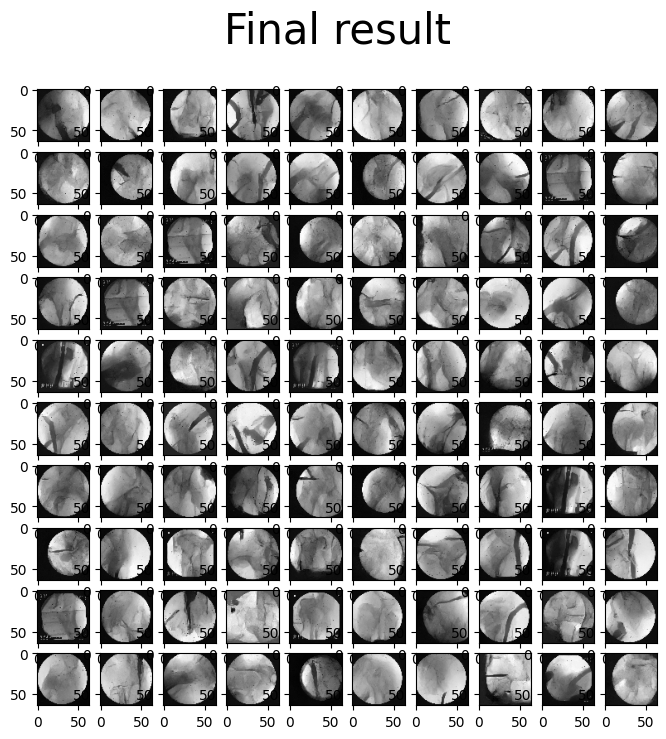

In [47]:
print("Generating new images")
generated = generate_new_images(
        best_model,
        n_samples=100,
        device=device,
        gif_name="fashion.gif" if fashion else "mnist.gif"
    )
show_images(generated, "Final result")

### FID (to be implemented)

Reference: https://pytorch.org/ignite/generated/ignite.metrics.FID.html